<a href="https://colab.research.google.com/github/JerKeller/MP-Ecotaxa/blob/main/ecotaxa_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries, dataset, extract colums needed

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import sys
import subprocess
from plotnine import ggplot, aes, geom_point, geom_line, labs, ggtitle, scale_y_log10
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [126]:
ecotaxa_export = '/content/drive/MyDrive/Ecotaxa_analysis/ecotaxa_export_yr.tsv'
tsv_read = pd.read_csv(ecotaxa_export, sep='\t')

Extract columns needed

In [127]:
sub1 = tsv_read[['object_id', 'object_date', 'object_depth_min', 'object_depth_max', 'object_annotation_category',
                 'object_area', 'object_area_exc', 'object_major', 'object_minor', 'sample_tot_vol', 'process_particle_pixel_size_mm',
                 'acq_id']]

Modify names of columns

In [128]:
sub1.columns = ['Label', 'Date', 'Min_depth', 'Max_depth', 'Taxa', 'area', 'areaExc', 'major', 'minor',
                'Tow_Vol', 'pixel_size_mm', 'acq_id']

Remove not living organisms

In [129]:
sub2 = sub1[(sub1['Taxa'] != 'badfocus<artefact') & (sub1['Taxa'] != 'fiber<detritus') &
            (sub1['Taxa'] != 'multiple<other') & (sub1['Taxa'] != 'detritus') &
            (sub1['Taxa'] != 'egg sac<egg') & (sub1['Taxa'] != 't001') &
            (sub1['Taxa'] != 't002') & (sub1['Taxa'] != 't003') &
            (sub1['Taxa'] != 'othertocheck') & (sub1['Taxa'] != 'artefact') &
            (sub1['Taxa'] != 'bubble') & (sub1['Taxa'] != 'dead<Copepoda')].copy()


## Stratif water column analysis

Exclude samples not needed yet

In [130]:
substrat = sub2[~sub2['acq_id'].isin(['tot_n10_221027', 'tot_n9_221013', 'tot_n14_221103',
                                           'tot_n19_221110', 'tot_n24_221221', 'tot_n25_221221',
                                           'tot_n26_221221', 'tot_n27_221221', 'tot_n28_221221',
                                           'tot_n29_221221','tot_n32_230105','tot_n35_230118',
                                          'tot_n38_230209','tot_n41_230209','tot_n42_230209',
                                          'tot_n43_230216','tot_n46_230222','tot_n49_230216',
                                          'tot_n53_230222','tot_n56_230209','tot_n61_230209','tot_n64_230209',
                                          'tot_n65_230216','tot_n70_230222','tot_n73_230216',
                                          'tot_n79_230222','tot_n80_230222'])].copy()

Date format

In [131]:
substrat['Date'] = pd.to_datetime(substrat['Date'], format='%Y%m%d')

Conversions from pixel to mm

In [132]:
# Conversions from pixel to mm
substrat['Area_mm2'] = substrat['area'] * ((substrat['pixel_size_mm']) ** 2)
substrat['AreaExc_mm2'] = substrat['areaExc'] * ((substrat['pixel_size_mm']) ** 2)
substrat['Major_mm'] = substrat['major'] * substrat['pixel_size_mm']
substrat['Minor_mm'] = substrat['minor'] * substrat['pixel_size_mm']

Ellipsoidal Volume = V (mm3) = 4/3 x ∏ x [ (Major(mm)/2) x (Minor(mm)/2) x (Minor(mm)/2) ]

In [133]:
substrat['V_mm3'] = (4 / 3) * np.pi * ((substrat['Major_mm'] / 2) * (substrat['Minor_mm'] / 2) * (substrat['Minor_mm'] / 2))

In [ ]:
print(substrat)

                     Label       Date  Min_depth  Max_depth  \
0        49_230302_tot_1_1 2023-03-02        0.0      100.0   
2        49_230302_tot_1_3 2023-03-02        0.0      100.0   
4        49_230302_tot_1_5 2023-03-02        0.0      100.0   
5        49_230302_tot_1_6 2023-03-02        0.0      100.0   
6        49_230302_tot_1_7 2023-03-02        0.0      100.0   
...                    ...        ...        ...        ...   
52866  n8_221013_tot_1_641 2022-10-13        0.0       50.0   
52867  n8_221013_tot_1_642 2022-10-13        0.0       50.0   
52868  n8_221013_tot_1_643 2022-10-13        0.0       50.0   
52871  n8_221013_tot_1_646 2022-10-13        0.0       50.0   
52872  n8_221013_tot_1_647 2022-10-13        0.0       50.0   

                       Taxa    area  areaExc  major  minor  Tow_Vol  \
0      Eudiaptomus gracilis  3223.0   3221.0   94.5   43.4   7.0686   
2      Eudiaptomus gracilis  1964.0   1964.0   69.0   36.3   7.0686   
4      Eudiaptomus gracilis  3

Creates a factor which allows binning by the log of the biovolume

In [134]:
substrat['logvol'] = np.log10(substrat['V_mm3'])

Create groups based on acq_id, taxa and date

In [135]:
grouped_data = substrat.groupby(['acq_id', 'Taxa', 'Date'])

In [14]:
print(grouped_data)

In [136]:
species_count_data = grouped_data.agg({'Taxa': 'count', 'Tow_Vol': 'mean'}).rename(columns={'Taxa': 'Count', 'Tow_Vol': 'tv'})

In [137]:
species_count_data.to_excel('species_count_data.xlsx', index=False)

In [17]:
print(species_count_data)

                                               Count      tv
acq_id        Taxa                 Date                     
tot_49_230302 Cyclops prealpinus   2023-03-02    118  7.0686
              Daphnia<Daphniidae   2023-03-02      3  7.0686
              Eubosmina sp         2023-03-02      2  7.0686
              Eudiaptomus gracilis 2023-03-02    338  7.0686
              nauplii<Copepoda     2023-03-02    100  7.0686
...                                              ...     ...
tot_n8_221013 Daphnia<Daphniidae   2022-10-13     75  3.5343
              Eubosmina sp         2022-10-13      4  3.5343
              Eudiaptomus gracilis 2022-10-13    228  3.5343
              Leptodora kindtii    2022-10-13      1  3.5343
              nauplii<Copepoda     2022-10-13     79  3.5343

[329 rows x 2 columns]


In [138]:
concentration_data = species_count_data.copy()
concentration_data['Concentration'] = concentration_data['Count'] / concentration_data['tv']
concentration_data.reset_index(inplace=True)

In [20]:
print(concentration_data)

            acq_id                  Taxa       Date  Count      tv  \
0    tot_49_230302    Cyclops prealpinus 2023-03-02    118  7.0686   
1    tot_49_230302    Daphnia<Daphniidae 2023-03-02      3  7.0686   
2    tot_49_230302          Eubosmina sp 2023-03-02      2  7.0686   
3    tot_49_230302  Eudiaptomus gracilis 2023-03-02    338  7.0686   
4    tot_49_230302      nauplii<Copepoda 2023-03-02    100  7.0686   
..             ...                   ...        ...    ...     ...   
324  tot_n8_221013    Daphnia<Daphniidae 2022-10-13     75  3.5343   
325  tot_n8_221013          Eubosmina sp 2022-10-13      4  3.5343   
326  tot_n8_221013  Eudiaptomus gracilis 2022-10-13    228  3.5343   
327  tot_n8_221013     Leptodora kindtii 2022-10-13      1  3.5343   
328  tot_n8_221013      nauplii<Copepoda 2022-10-13     79  3.5343   

     Concentration  
0        16.693546  
1         0.424412  
2         0.282941  
3        47.817107  
4        14.147073  
..             ...  
324      21.

In [139]:
biovolume_data = substrat.groupby(['Taxa', 'Date']).agg({'Tow_Vol': 'mean', 'V_mm3': 'sum'})
biovolume_data['Biovolume'] = biovolume_data['V_mm3'] / biovolume_data['Tow_Vol']
biovolume_data.reset_index(inplace=True)

concentration_data = concentration_data.merge(biovolume_data[['Taxa', 'Date','Biovolume']], on=['Taxa', 'Date'])

In [140]:
biovolume_data.to_excel('biovol.xlsx', index=False)

Total biovolume and concentration by sample

In [141]:
total_conc = concentration_data.groupby('acq_id').agg({'Count': 'sum', 'Concentration': 'sum', 'Biovolume': 'sum','Date': 'first'}).reset_index()

In [ ]:
print(total_conc)

            acq_id  Count  Concentration  Biovolume       Date
0    tot_49_230302    561      79.365079  22.290681 2023-03-02
1   tot_n11_221027   1113     157.456922  28.935765 2022-10-27
2   tot_n12_221103     45      12.732366  30.215413 2022-11-03
3   tot_n13_221103    839     237.387884  49.091389 2022-11-03
4   tot_n15_221108     64      18.108253  25.005606 2022-11-08
..             ...    ...            ...        ...        ...
59   tot_n7_221013     92      26.030614  16.891743 2022-10-13
60  tot_n80_230830    129      18.249724   4.779705 2023-08-30
61  tot_n81_230830     30       8.488244   3.758116 2023-08-30
62  tot_n82_230830     42      11.883541   3.758116 2023-08-30
63   tot_n8_221013    448     126.757774  22.662089 2022-10-13

[64 rows x 5 columns]


In [142]:
# Group the data by date and sum the values
total_conc = total_conc.groupby('Date').sum().reset_index()



<ipython-input-142-5ebf0b2ab91d>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [143]:
cyclopsEudia = ["Cyclops prealpinus","Eudiaptomus gracilis","nauplii<Copepoda"]
concentration_data_cyclops = concentration_data.query('Taxa in @cyclopsEudia')

DaphEubos = ["Daphnia<Daphniidae","Eubosmina sp"]
concentration_data_daph = concentration_data.query('Taxa in @DaphEubos')

LeptoBitho = ["Leptodora kindtii","Bythotrephes longimanus",]
concentration_data_lepto = concentration_data.query('Taxa in @LeptoBitho')

In [144]:
grouped_conc_data = concentration_data.groupby(['Taxa', 'Date'])['Concentration'].sum().reset_index()

In [145]:
group_cyclopsEudia = ["Cyclops prealpinus","Eudiaptomus gracilis","nauplii<Copepoda"]
grouped_data_cyclops = grouped_conc_data.query('Taxa in @group_cyclopsEudia')

group_dapheubo = ["Daphnia<Daphniidae","Eubosmina sp"]
grouped_data_dapheubo = grouped_conc_data.query('Taxa in @group_dapheubo')

group_leptobitho = ["Leptodora kindtii","Bythotrephes longimanus"]
grouped_data_leptobitho = grouped_conc_data.query('Taxa in @group_leptobitho')

### Plots

Total concentration plot

<ipython-input-146-c5cfbf618ab3>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



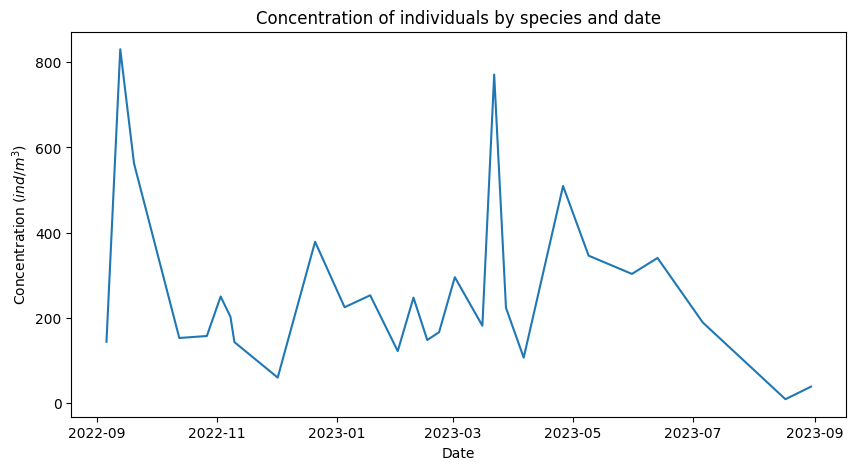

In [146]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", data=total_conc, markers=True, ci=None)
plt.title("Concentration of individuals by species and date")
plt.xlabel("Date")
plt.ylabel("Concentration ($ind/m^3$)")
plt.show()

<ipython-input-147-b4933afaa4de>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

<ipython-input-147-b4933afaa4de>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



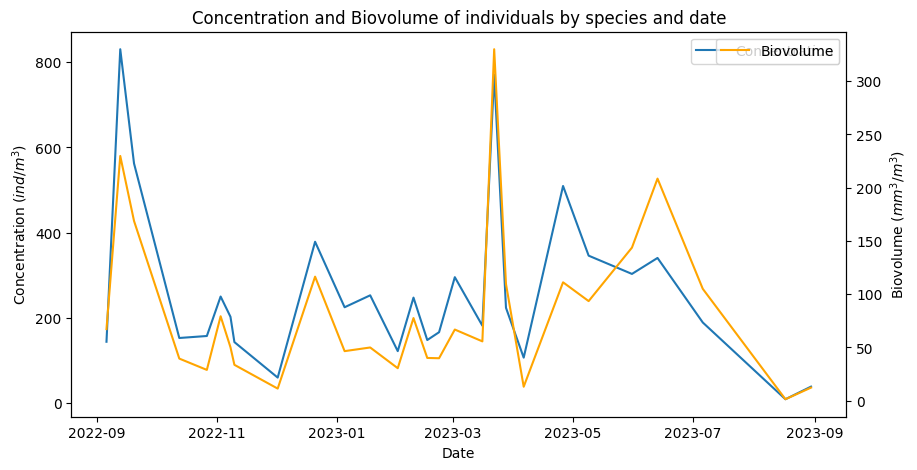

In [147]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# plot the first variable (Concentration) on the left y-axis
sns.lineplot(x="Date", y="Concentration", data=total_conc, markers=True, ax=ax1, ci=None, label = "Concentration")
ax1.set_xlabel('Date')
ax1.set_ylabel('Concentration ($ind/m^3$)')


ax2 = ax1.twinx()


sns.lineplot(x="Date", y="Biovolume", data=total_conc, markers=True, ax=ax2, color='orange', ci=None, label = "Biovolume")
ax2.set_ylabel('Biovolume ($mm^3/m^3$)')

plt.title("Concentration and Biovolume of individuals by species and date")
plt.legend()
plt.show()







Concentration by taxa

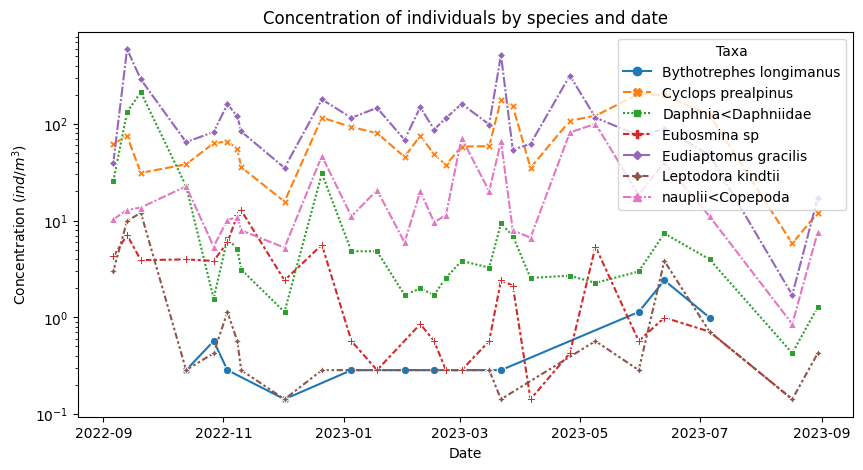

In [148]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", hue="Taxa", data=grouped_conc_data, style="Taxa", markers=True)
plt.yscale("log") # add logarithmic scale
plt.title("Concentration of individuals by species and date")
plt.xlabel("Date")
plt.ylabel("Concentration ($ind/m^3$)")
plt.show()

Biovolume for Cyclops, eudiaptomus and nauplii

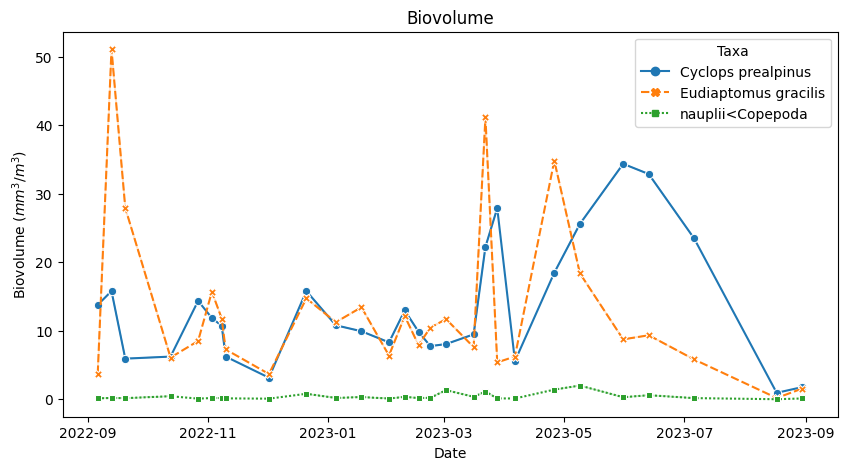

In [149]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Biovolume", hue="Taxa", data=concentration_data_cyclops, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Biovolume")
plt.xlabel("Date")
plt.ylabel("Biovolume ($mm^3$/$m^3$)")
plt.show()

Concentration for cyclops, eudiaptomus and nauplii

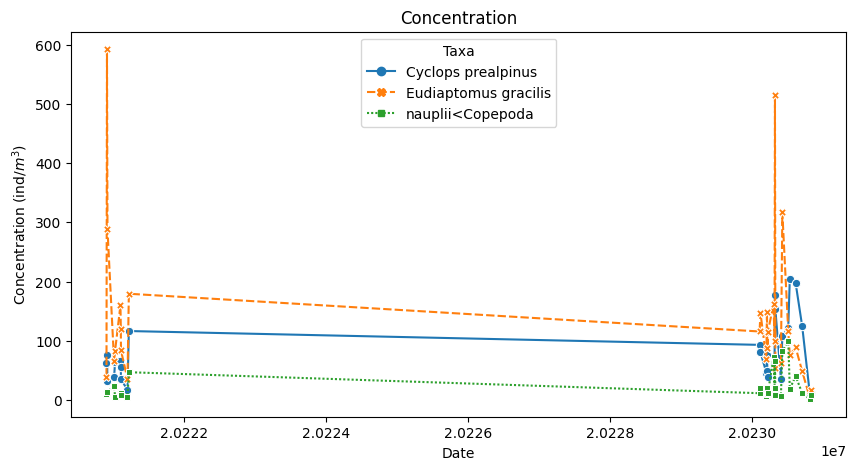

In [26]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", hue="Taxa", data=grouped_data_cyclops, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Concentration")
plt.xlabel("Date")
plt.ylabel("Concentration (ind/$m^3$)")
plt.show()

Biovolume for daphnia and eubosmina

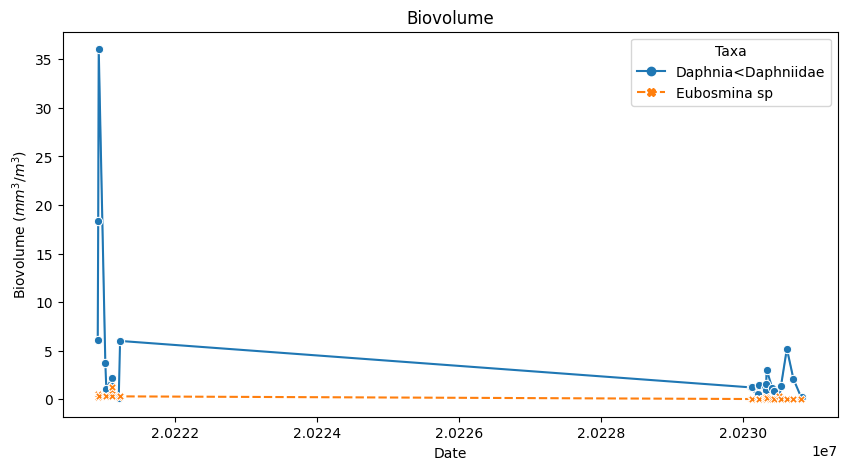

In [27]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Biovolume", hue="Taxa", data=concentration_data_daph, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Biovolume")
plt.xlabel("Date")
plt.ylabel("Biovolume ($mm^3$/$m^3$)")
plt.show()

Concentration for daphnia and eubosmina

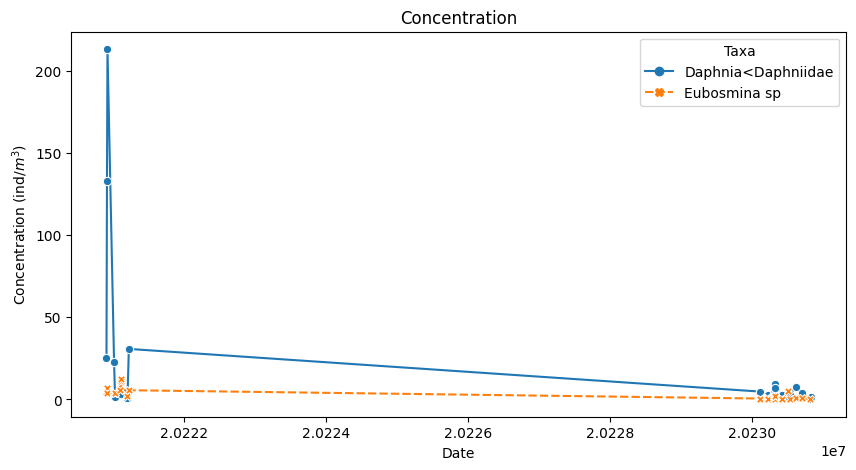

In [28]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", hue="Taxa", data=grouped_data_dapheubo, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Concentration")
plt.xlabel("Date")
plt.ylabel("Concentration (ind/$m^3$)")
plt.show()

Biovolume for bythotrephes and leptodora

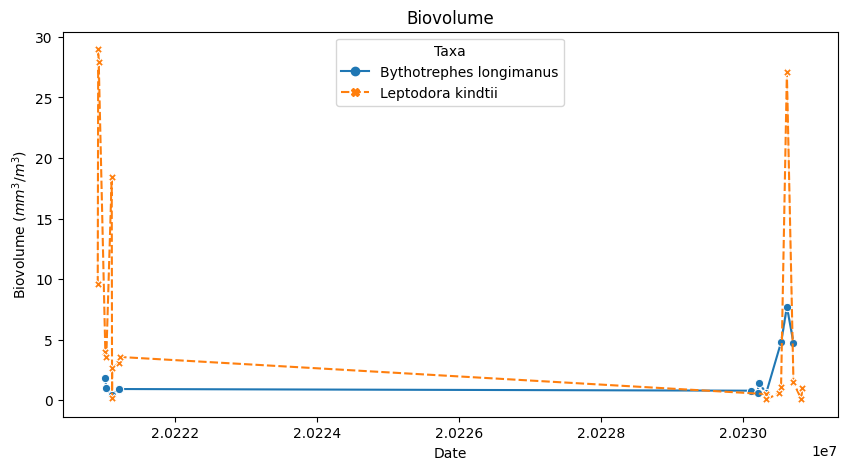

In [29]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Biovolume", hue="Taxa", data=concentration_data_lepto, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Biovolume")
plt.xlabel("Date")
plt.ylabel("Biovolume ($mm^3$/$m^3$)")
plt.show()

Concentration for bythotrephes and leptodora

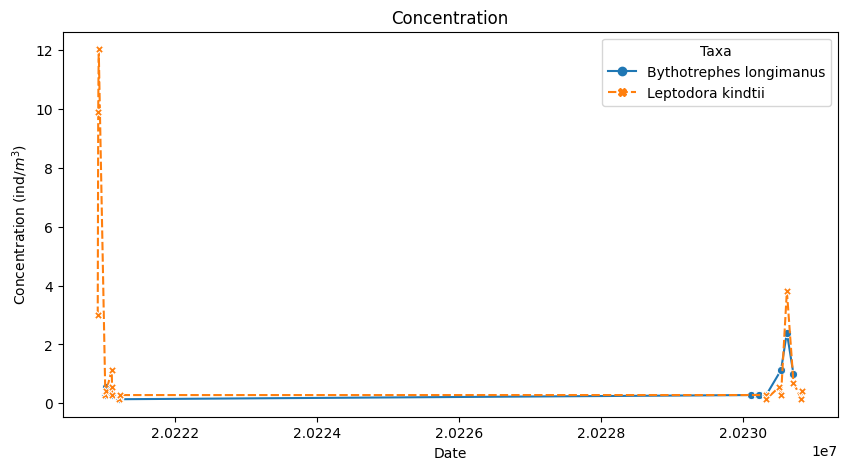

In [30]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", hue="Taxa", data=grouped_data_leptobitho, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Concentration")
plt.xlabel("Date")
plt.ylabel("Concentration (ind/$m^3$)")
plt.show()

In [31]:
species_to_plot = ["cyclops préalpinus", "eudiaptomus gracilis"]
concentration_data_filtered = concentration_data.query('Taxa in @species_to_plot')

In [32]:
grouped_conc_data = grouped_conc_data.sort_values(by='Date')

In [33]:
grouped_conc_data['Date'] = grouped_conc_data['Date'].dt.date

AttributeError: ignored

<ipython-input-34-8916f74b498e>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



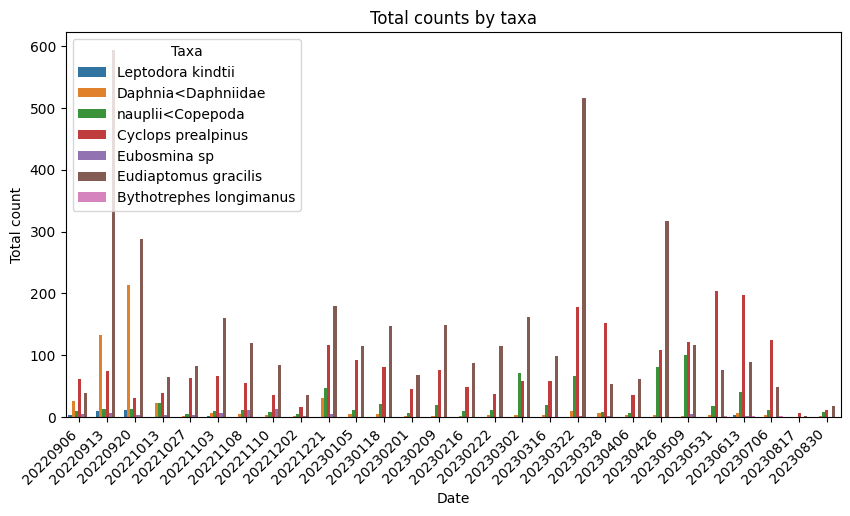

In [34]:
plt.figure(figsize=(10,5))
sns.barplot(x="Date", y="Concentration",hue="Taxa", data=grouped_conc_data, ci=None)
plt.title("Total counts by taxa")
plt.xlabel("Date")
plt.ylabel("Total count")
plt.xticks(rotation=45, ha='right')
plt.show()

In [35]:
concentration_data = concentration_data.sort_values(by='Date')



<Figure size 1000x500 with 0 Axes>

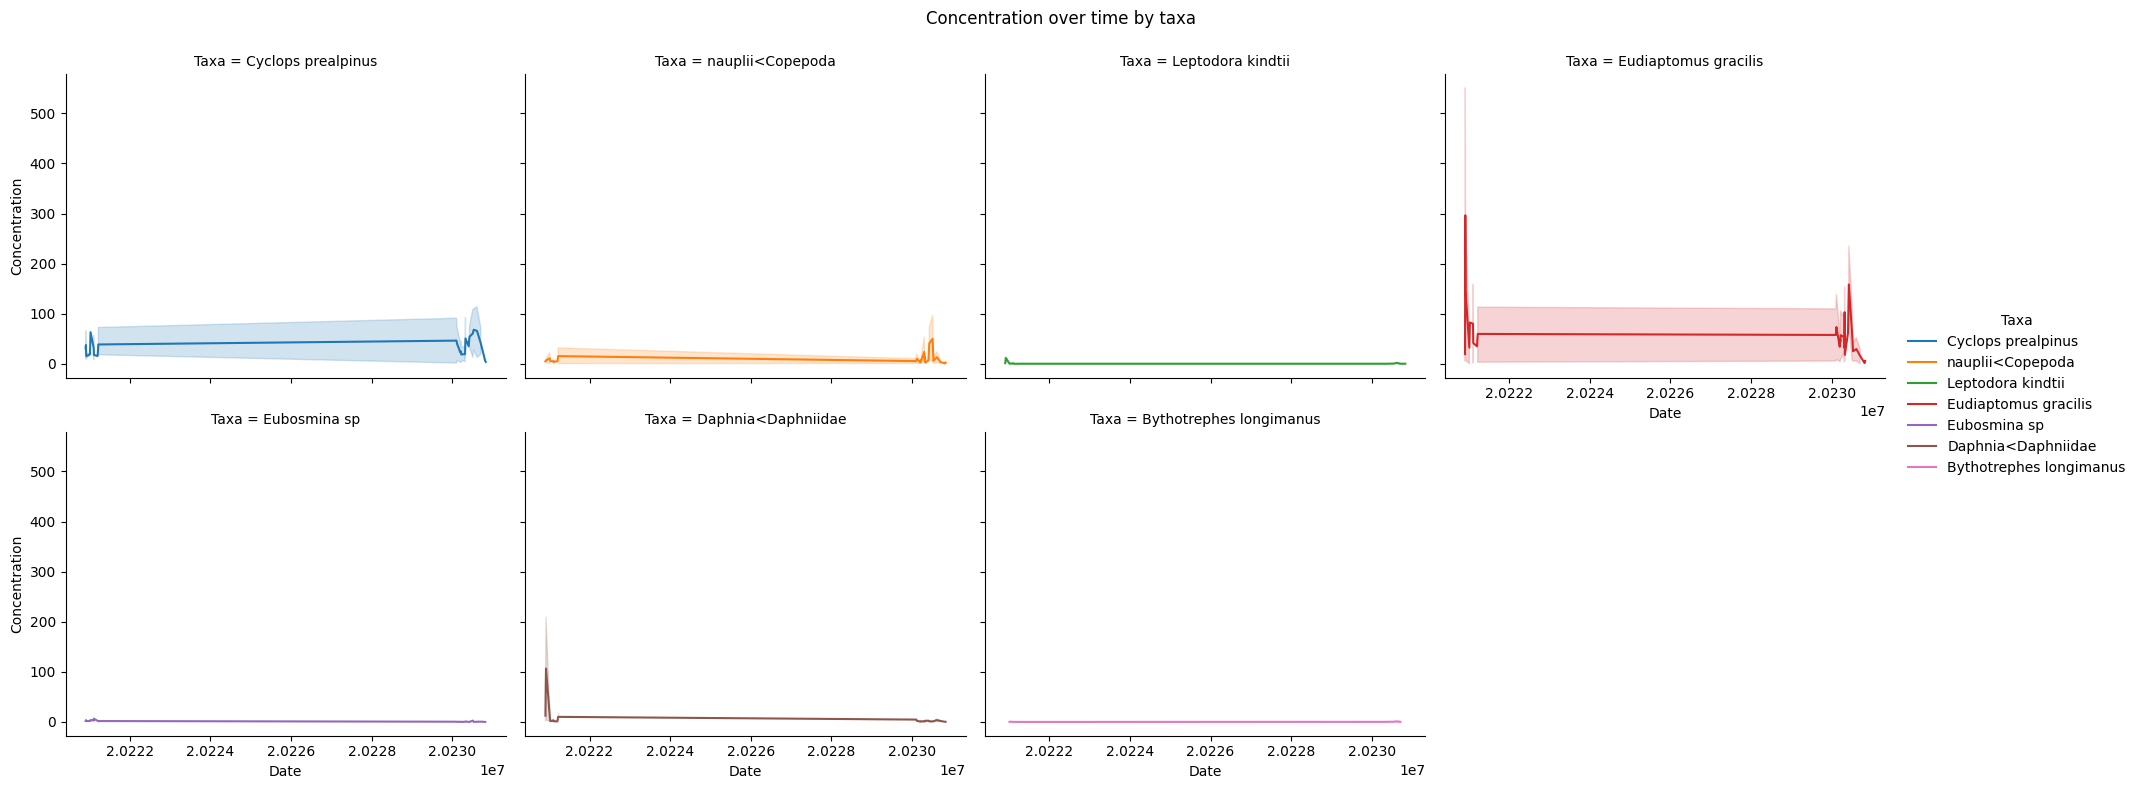

In [36]:
plt.figure(figsize=(10,5))
sns.relplot(x="Date", y="Concentration", hue="Taxa", kind="line", col="Taxa", col_wrap=4, data=concentration_data, height=4, aspect=1.2)
plt.subplots_adjust(top=0.9)
plt.suptitle("Concentration over time by taxa")
plt.show()

## 100-0 water column analysis

In [103]:
sub100 = sub2[sub2['acq_id'].isin(['tot_n10_221027', 'tot_n9_221013', 'tot_n14_221103',
                                           'tot_n19_221110', 'tot_n20_221221','tot_n32_230105','tot_n35_230118',
                                          'tot_n38_230209',
                                          'tot_n43_230216','tot_n46_230222','tot_n49_230303 ','tot_n53_230316', 'tot_n56_230322','tot_n61_230328','tot_n64_230406','tot_n65_230426',
                                   'tot_n70_230531','tot_n73_230613','tot_n76_230216','tot_n79_230817','tot_n80_230830'])].copy()

In [125]:
print(sub100)

                      Label       Date  Min_depth  Max_depth  \
669      n10_221027_tot_1_1 2022-10-27        0.0      100.0   
670      n10_221027_tot_1_2 2022-10-27        0.0      100.0   
671      n10_221027_tot_1_3 2022-10-27        0.0      100.0   
672      n10_221027_tot_1_4 2022-10-27        0.0      100.0   
673      n10_221027_tot_1_5 2022-10-27        0.0      100.0   
...                     ...        ...        ...        ...   
54333  n9_221013_tot_1_1461 2022-10-13        0.0      100.0   
54334  n9_221013_tot_1_1462 2022-10-13        0.0      100.0   
54335  n9_221013_tot_1_1463 2022-10-13        0.0      100.0   
54339  n9_221013_tot_1_1467 2022-10-13        0.0      100.0   
54340  n9_221013_tot_1_1468 2022-10-13        0.0      100.0   

                       Taxa    area  areaExc  major  minor  Tow_Vol  \
669    Eudiaptomus gracilis  4241.0   4240.0   77.1   70.1   7.0686   
670    Eudiaptomus gracilis  4203.0   4044.0  113.8   47.0   7.0686   
671    Eudiaptomus

In [104]:
sub100['Date'] = pd.to_datetime(sub100['Date'], format='%Y%m%d')

In [105]:
sub100['Area_mm2'] = sub100['area'] * ((sub100['pixel_size_mm']) ** 2)
sub100['AreaExc_mm2'] = sub100['areaExc'] * ((sub100['pixel_size_mm']) ** 2)
sub100['Major_mm'] = sub100['major'] * sub100['pixel_size_mm']
sub100['Minor_mm'] = sub100['minor'] * sub100['pixel_size_mm']

In [106]:
sub100['V_mm3'] = (4 / 3) * np.pi * ((sub100['Major_mm'] / 2) * (sub100['Minor_mm'] / 2) * (sub100['Minor_mm'] / 2))

In [113]:
grouped_data100 = sub100.groupby(['acq_id', 'Taxa', 'Date'])
species_count_data100 = grouped_data100.agg({'Taxa': 'count', 'Tow_Vol': 'mean'}).rename(columns={'Taxa': 'Count', 'Tow_Vol': 'tv'})

In [114]:
concentration_data100 = species_count_data100.copy()
concentration_data100['Concentration'] = concentration_data100['Count'] / concentration_data100['tv']
concentration_data100.reset_index(inplace=True)

In [115]:
biovolume_data100 = sub100.groupby(['Taxa', 'Date']).agg({'Tow_Vol': 'mean', 'V_mm3': 'sum'})
biovolume_data100['Biovolume'] = biovolume_data100['V_mm3'] / biovolume_data100['Tow_Vol']
biovolume_data100.reset_index(inplace=True)

concentration_data100 = concentration_data100.merge(biovolume_data100[['Taxa', 'Date','Biovolume']], on=['Taxa', 'Date'])

In [116]:
total_conc100 = concentration_data100.groupby('acq_id').agg({'Count': 'sum', 'Concentration': 'sum', 'Biovolume': 'sum','Date': 'first'}).reset_index()

In [117]:
total_conc100 = total_conc100.drop('acq_id', axis=1)

In [118]:
total_conc100 = total_conc100.groupby('Date').sum().reset_index()

In [119]:
date_column = total_conc100.pop("Date")
total_conc100.insert(0, "Date", date_column)

In [85]:
total_conc100.to_excel('total_conc100.xlsx', index=False)

In [120]:
cyclopsEudia100 = ["Cyclops prealpinus","Eudiaptomus gracilis","nauplii<Copepoda"]
concentration_data_cyclops100 = concentration_data100.query('Taxa in @cyclopsEudia')

DaphEubos100 = ["Daphnia<Daphniidae","Eubosmina sp"]
concentration_data_daph100 = concentration_data100.query('Taxa in @DaphEubos')

LeptoBitho100 = ["Leptodora kindtii","Bythotrephes longimanus",]
concentration_data_lepto100 = concentration_data100.query('Taxa in @LeptoBitho')

In [121]:
grouped_conc_data100 = concentration_data100.groupby(['Taxa', 'Date'])['Concentration'].sum().reset_index()

In [122]:
group_cyclopsEudia100 = ["Cyclops prealpinus","Eudiaptomus gracilis","nauplii<Copepoda"]
grouped_data_cyclops100 = grouped_conc_data100.query('Taxa in @group_cyclopsEudia')

group_dapheubo100 = ["Daphnia<Daphniidae","Eubosmina sp"]
grouped_data_dapheubo100 = grouped_conc_data100.query('Taxa in @group_dapheubo')

group_leptobitho100 = ["Leptodora kindtii","Bythotrephes longimanus"]
grouped_data_leptobitho100 = grouped_conc_data100.query('Taxa in @group_leptobitho')

### Plots

<ipython-input-123-2dfe73b2d029>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



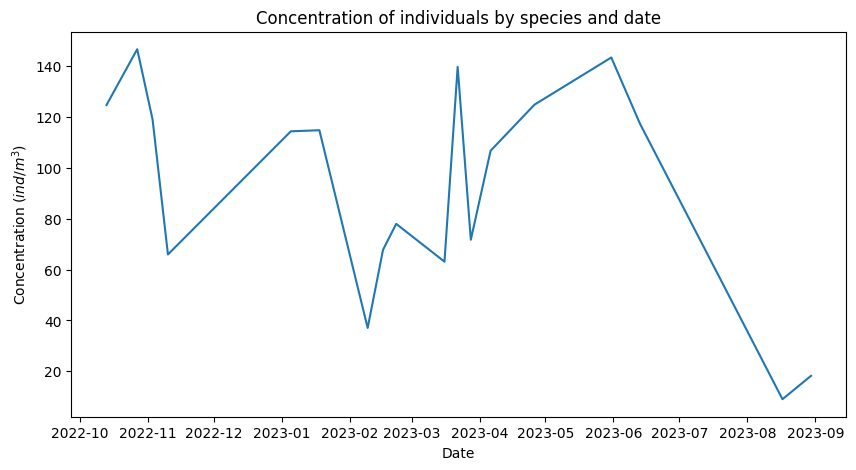

In [123]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", data=total_conc100, markers=True, ci=None)
plt.title("Concentration of individuals by species and date")
plt.xlabel("Date")
plt.ylabel("Concentration ($ind/m^3$)")
plt.show()

In [124]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# plot the first variable (Concentration) on the left y-axis
sns.lineplot(x="Date", y="Concentration", data=total_conc100, markers=True, ax=ax1, ci=None, label = "100-0")
ax1.set_xlabel('Date')
ax1.set_ylabel('Concentration ($ind/m^3$)')




sns.lineplot(x="Date", y="Concentration", data=total_conc, markers=True, ax=ax1, color='orange', ci=None, label = "100-50 + 50-0")
ax1.set_ylabel('Concentration ($mm^3/m^3$)')

plt.title("Concentration and Biovolume of individuals by species and date")
plt.legend()
plt.show()

<ipython-input-124-20f0b16cf485>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

<ipython-input-124-20f0b16cf485>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



ValueError: ignored

<Figure size 1000x500 with 1 Axes>

In [93]:
print(total_conc)

        Date  Count  Concentration   Biovolume
0   20220906    448     143.947484   67.225017
1   20220913   1754     830.619355  229.840115
2   20220920    954     562.353443  168.791239
3   20221013    540     152.788388   39.553832
4   20221027   1113     157.456922   28.935765
5   20221103    884     250.120250   79.306802
6   20221108    716     202.586085   50.234106
7   20221110    506     143.168378   33.701278
8   20221202    423      59.842119   11.379071
9   20221221    712     378.672093  116.493656
10  20230105    795     224.944593   46.551290
11  20230118    894     252.956822   49.986836
12  20230201    431     121.951220   30.530782
13  20230209    875     247.580782   77.603796
14  20230216    523     147.978383   40.162258
15  20230222    588     166.369578   39.883469
16  20230302   1325     295.532354   66.828954
17  20230316    865     181.648417   55.725489
18  20230322   3219     771.156948  330.075177
19  20230328   1044     223.665224  109.582356
20  20230406 

In [94]:
print(total_conc100)

         Date  Count  Concentration  Biovolume
0  2022-10-13    881     124.635713  19.392886
1  2022-10-27   1036     146.563676  26.640579
2  2022-11-03    841     118.976884  29.417163
3  2022-11-10    466      65.925360   8.497555
4  2023-01-05    808     114.308350  12.494875
5  2023-01-18    811     114.732762  11.910397
6  2023-02-09    262      37.065331   4.272093
7  2023-02-16    479      67.764480   8.343480
8  2023-02-22    551      77.950372   9.027663
9  2023-03-16    446      63.095945   7.578737
10 2023-03-22    987     139.631610  14.325329
11 2023-03-28    507      71.725660  13.516709
12 2023-04-06    754     106.668930  13.127174
13 2023-04-26    882     124.777184  18.137044
14 2023-05-31   1013     143.309849  27.846240
15 2023-06-13    830     117.420706  24.960268
16 2023-08-17     64       9.054127   1.399296
17 2023-08-30    129      18.249724   2.996708


In [96]:
print(sample_comparison)

NameError: ignored

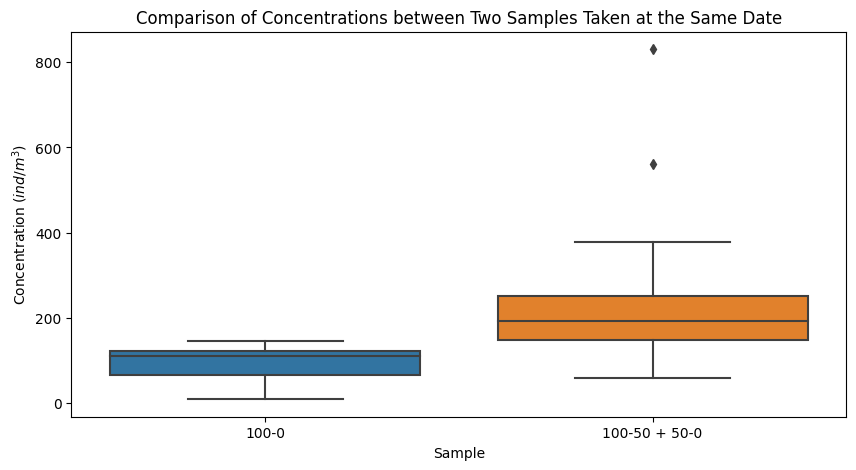

In [97]:
# create a new DataFrame with the concentrations for the two samples taken at each date
sample_comparison = pd.DataFrame()
sample_comparison['100-0'] = total_conc100['Concentration']
sample_comparison['100-50 + 50-0'] = total_conc['Concentration']

# create a grouped box plot to compare the distribution of concentrations between the two samples taken at each date
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=sample_comparison, ax=ax)
ax.set_xlabel('Sample')
ax.set_ylabel('Concentration ($ind/m^3$)')
ax.set_title('Comparison of Concentrations between Two Samples Taken at the Same Date')
plt.show()

In [98]:
merged = pd.merge(total_conc, total_conc100, on='Date', suffixes=('_total', '_total100'))
merged = merged[['Date', 'Concentration_total', 'Concentration_total100']]
merged['Difference'] = merged['Concentration_total'] - merged['Concentration_total100']


ValueError: ignored

In [99]:
merged['Difference'] = abs(merged['Difference'])

NameError: ignored

In [100]:
print(merged)

NameError: ignored

In [101]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the x-axis labels
dates = merged['Date'].dt.strftime('%Y-%m-%d').tolist()

# Set the bar width
bar_width = 0.35

# Create the bar plots
plt.bar(range(len(dates)), merged['Concentration_total'], width=bar_width, label='total_conc')
plt.bar([i + bar_width for i in range(len(dates))], merged['Concentration_total100'], width=bar_width, label='total_conc100')

# Set the x-axis tick labels
plt.xticks([i + bar_width/2 for i in range(len(dates))], dates, rotation=45)

# Set the axis labels and title
plt.xlabel('Sampling Date')
plt.ylabel('Concentration')
plt.title('Variability between total_conc and total_conc100')

# Add a legend
plt.legend()

# Show the plot
plt.show()







NameError: ignored

<Figure size 1000x600 with 0 Axes>

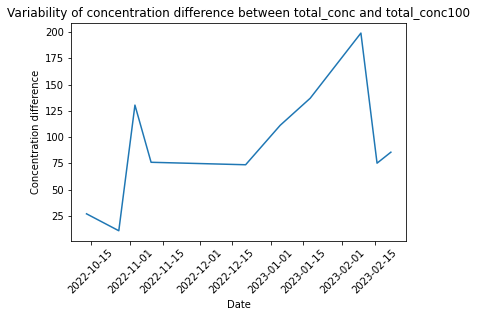

In [ ]:
sns.lineplot(x='Date', y='Difference', data=merged)
plt.xticks(rotation=45)
plt.title('Variability of concentration difference between total_conc and total_conc100')
plt.xlabel('Date')
plt.ylabel('Concentration difference')
plt.show()

NameError: ignored

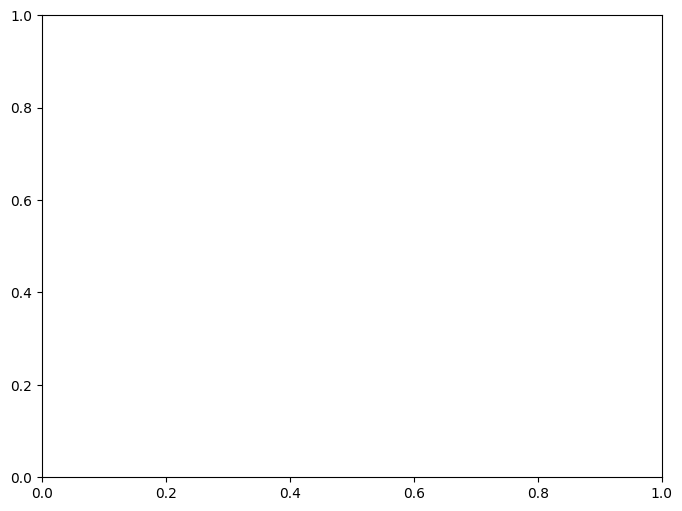

In [102]:

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=merged[['Concentration_total', 'Concentration_total100']].abs(), ax=ax)
ax.set_ylabel('Concentration (cells/mL)')
ax.set_xlabel('Sample')
ax.set_xticklabels(['Concentration_total', 'Concentration_total100'])
plt.show()